# Random Forest

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Carica i dati dal CSV
data = pd.read_csv('histograms_features.csv')

# Separare le feature (i bin degli istogrammi) e le etichette
X = data.drop(columns=['Label'])  # Tutte le colonne tranne 'Label' sono le feature
y = data['Label']  # La colonna 'Label' è la variabile target

# Codifica le etichette in numeri (per i classificatori che richiedono numeri)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dividi il dataset in training e testing (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Crea il modello Random Forest
model = RandomForestClassifier(n_estimators=5000, random_state=42)

# Allena il modello sui dati di training
model.fit(X_train, y_train)

# Fai delle previsioni sui dati di test
y_pred = model.predict(X_test)

# Valuta le performance del modello
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Report di classificazione per maggiori dettagli sulle performance
print("\nClassification Report:")
print(classification_report(y_test, y_pred, labels=label_encoder.transform(label_encoder.classes_),
                            target_names=label_encoder.classes_, zero_division=0))


Accuracy: 73.44%

Classification Report:
                         precision    recall  f1-score   support

        Aussie Lemonade       0.62      0.62      0.62         8
             Mango Loco       0.79      0.69      0.73        16
         Original green       0.70      0.64      0.67        11
          Pacific Punch       0.67      0.60      0.63        10
    java salted caramel       0.80      0.50      0.62         8
                lo carb       0.64      1.00      0.78         9
     nitro cosmic peach       0.61      0.85      0.71        13
        nitro super dry       0.64      0.64      0.64        11
           tea lemonade       0.67      0.50      0.57         4
            ultra black       0.00      0.00      0.00         3
             ultra blue       1.00      0.60      0.75         5
             ultra gold       1.00      0.75      0.86         4
      ultra peachy keen       1.00      0.71      0.83         7
              ultra red       0.80      0.67    

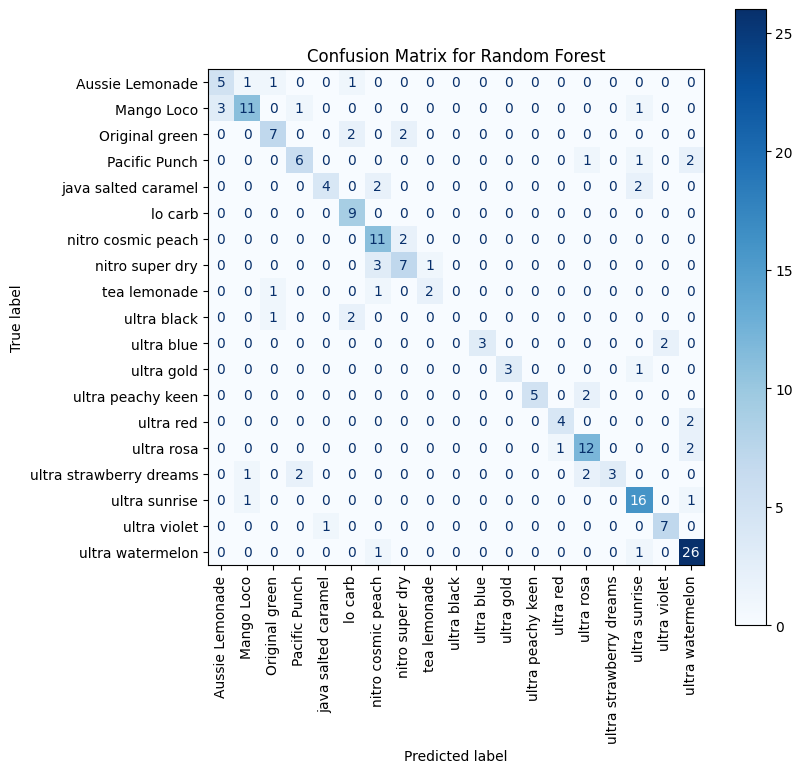

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(8, 8))  # Increase the size of the plot
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix for Random Forest')
plt.xticks(rotation=90)  # Rotate x-axis labels to vertical
plt.show()

# SVM

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Carica i dati dal CSV
data = pd.read_csv('histograms_features.csv')

# Separare le feature (i bin degli istogrammi) e le etichette
X = data.drop(columns=['Label'])  # Tutte le colonne tranne 'Label' sono le feature
y = data['Label']  # La colonna 'Label' è la variabile target

# Codifica le etichette in numeri (per i classificatori che richiedono numeri)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dividi il dataset in training e testing (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Crea il modello Random Forest
model = SVC(kernel='linear', random_state=42)

# Allena il modello sui dati di training
model.fit(X_train, y_train)

# Fai delle previsioni sui dati di test
y_pred = model.predict(X_test)

# Valuta le performance del modello
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Report di classificazione per maggiori dettagli sulle performance
print("\nClassification Report:")
print(classification_report(y_test, y_pred, labels=label_encoder.transform(label_encoder.classes_),
                            target_names=label_encoder.classes_, zero_division=0))


Accuracy: 70.31%

Classification Report:
                         precision    recall  f1-score   support

        Aussie Lemonade       0.62      0.62      0.62         8
             Mango Loco       0.80      0.50      0.62        16
         Original green       0.50      0.36      0.42        11
          Pacific Punch       0.58      0.70      0.64        10
    java salted caramel       0.88      0.88      0.88         8
                lo carb       0.89      0.89      0.89         9
     nitro cosmic peach       0.90      0.69      0.78        13
        nitro super dry       0.67      0.36      0.47        11
           tea lemonade       0.29      0.50      0.36         4
            ultra black       0.20      1.00      0.33         3
             ultra blue       0.50      0.60      0.55         5
             ultra gold       0.25      0.75      0.38         4
      ultra peachy keen       0.80      0.57      0.67         7
              ultra red       0.83      0.83    

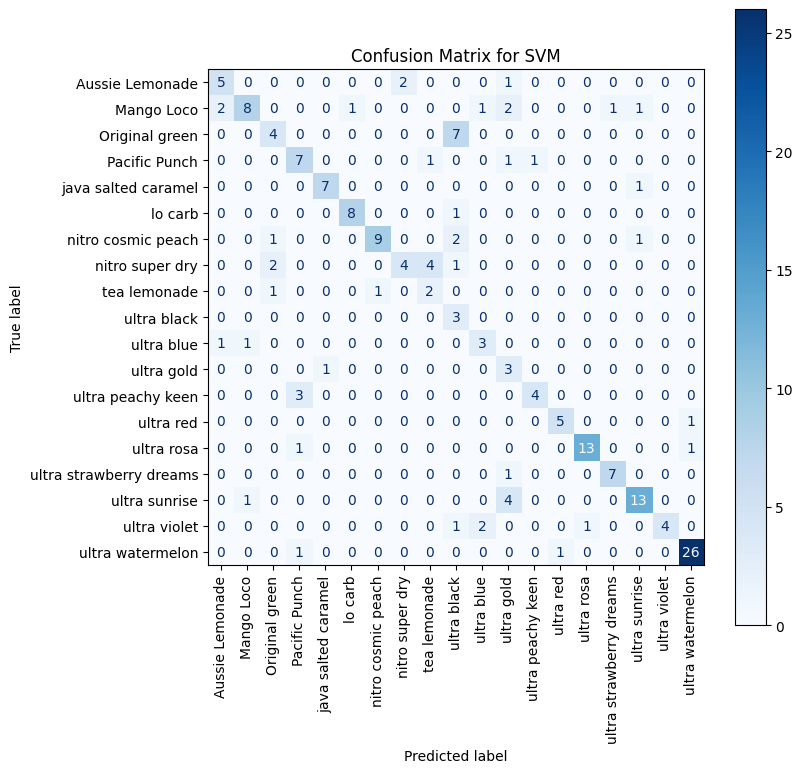

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(8, 8))  # Increase the size of the plot
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix for SVM')
plt.xticks(rotation=90)  # Rotate x-axis labels to vertical
plt.show()

# MLP Classifier

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Carica i dati dal CSV
data = pd.read_csv('histograms_features.csv')

# Separare le feature (i bin degli istogrammi) e le etichette
X = data.drop(columns=['Label'])  # Tutte le colonne tranne 'Label' sono le feature
y = data['Label']  # La colonna 'Label' è la variabile target

# Codifica le etichette in numeri (per i classificatori che richiedono numeri)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dividi il dataset in training e testing (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Crea il modello Random Forest
model = MLPClassifier(hidden_layer_sizes=(1000,), max_iter=10000, random_state=42)

# Allena il modello sui dati di training
model.fit(X_train, y_train)

# Fai delle previsioni sui dati di test
y_pred = model.predict(X_test)

# Valuta le performance del modello
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Report di classificazione per maggiori dettagli sulle performance
print("\nClassification Report:")
print(classification_report(y_test, y_pred, labels=label_encoder.transform(label_encoder.classes_),
                            target_names=label_encoder.classes_, zero_division=0))


Accuracy: 75.00%

Classification Report:
                         precision    recall  f1-score   support

        Aussie Lemonade       0.67      0.75      0.71         8
             Mango Loco       1.00      0.56      0.72        16
         Original green       0.71      0.45      0.56        11
          Pacific Punch       0.83      0.50      0.62        10
    java salted caramel       1.00      0.75      0.86         8
                lo carb       0.62      0.89      0.73         9
     nitro cosmic peach       0.65      1.00      0.79        13
        nitro super dry       1.00      0.45      0.62        11
           tea lemonade       0.60      0.75      0.67         4
            ultra black       0.38      1.00      0.55         3
             ultra blue       1.00      1.00      1.00         5
             ultra gold       0.44      1.00      0.62         4
      ultra peachy keen       1.00      0.71      0.83         7
              ultra red       1.00      0.67    

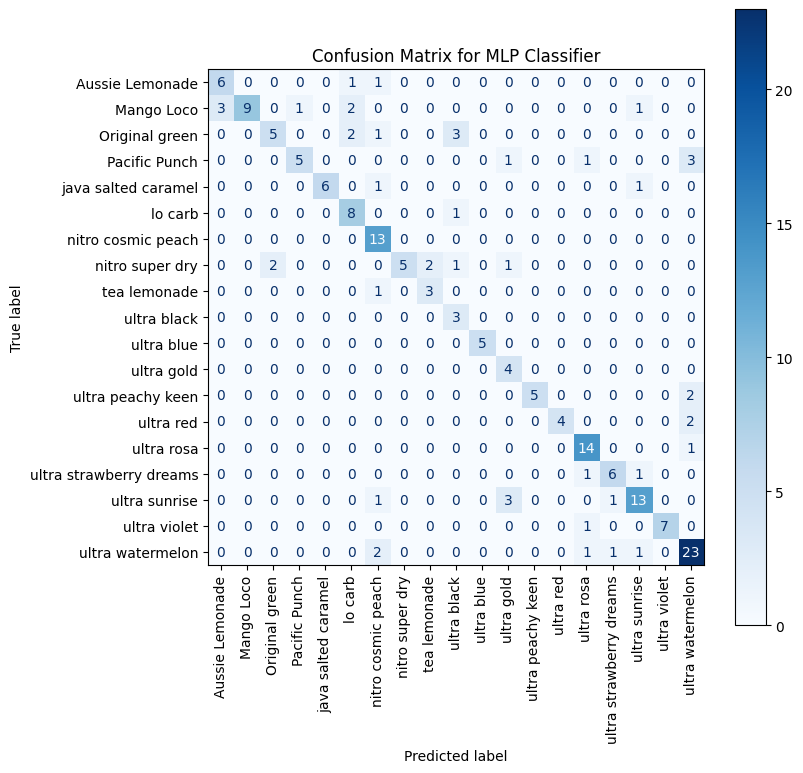

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(8, 8))  # Increase the size of the plot
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix for MLP Classifier')
plt.xticks(rotation=90)  # Rotate x-axis labels to vertical
plt.show()